In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report


import os

RANDOM_STATE = 42


In [ ]:
# NOTE: need subdirectories of this current directory, this creates them
os.mkdir("./models")
os.mkdir("./data")

# Place dataset parquet files in data, and everything should run as intended


In [28]:
# These were originally defined in other files, I'm not that unorganized
import torch

class ResNet_Block(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNet_Block, self).__init__()

        # Note: conv1d expects inputs of shape (batch_size, channels, length)
        # So in our case (batch_size, 1, len(datapoint))
        self.conv1 = torch.nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = torch.nn.BatchNorm1d(num_features=out_channels)
        self.relu = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv1d(in_channels=out_channels, out_channels=in_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = torch.nn.BatchNorm1d(num_features=in_channels)

        self.conv3 = torch.nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn3 = torch.nn.BatchNorm1d(num_features=out_channels)

        # Downsample if an odd stride shape causes mismatch in shapes that would prevent skip connection addition
        self.downsample = None
        if stride != 1 or in_channels != out_channels: 
            self.downsample = torch.nn.Sequential(
                torch.nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                torch.nn.BatchNorm1d(out_channels)
            )
    
    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.downsample:
            identity = self.downsample(identity)
        
        x += identity

        x = self.relu(x)

        return x

# Deep Neural Network - ResNet block, BiGRU block, attention layer, inference layer in the paper
# We'll start with just ResNet depending on time constraints
class DNN(torch.nn.Module):
    def __init__(self, num_scalar_features, output_channels: int = 16):
        super(DNN, self).__init__()
        self.num_classes = 2
        self.input_channels = 3
        self.output_channels = output_channels
        self.num_scalar_features = num_scalar_features

        # ResNet
        # Layers inspired by: https://medium.com/@siddheshb008/resnet-architecture-explained-47309ea9283d
        self.conv = torch.nn.Conv1d(in_channels=self.input_channels, out_channels=self.input_channels, kernel_size=3, stride=1, padding=1)
        self.bn = torch.nn.BatchNorm1d(num_features=self.input_channels)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool1d(kernel_size=2, stride=2)

        self.res_block1 = ResNet_Block(self.input_channels, self.output_channels, stride=1)
        self.res_block2 = ResNet_Block(self.output_channels, self.output_channels*2, stride=1)
        self.res_block3 = ResNet_Block(self.output_channels*2, self.output_channels*4, stride=1)

        self.avgpool = torch.nn.AdaptiveAvgPool1d(1)
        self.fc = torch.nn.Linear(self.output_channels*4 + self.num_scalar_features, self.num_classes)

    def forward(self, x, scalar_features):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)

        x = self.avgpool(x)
        x = x.squeeze(-1)

        x = torch.cat([x, scalar_features.float()], dim=1)
        x = self.fc(x)
        return x       


from torch.utils.data import Dataset


class Bot_Dataset(Dataset):
    # Takes full path to data directory
    def __init__(self, path):
        bot_df = pd.read_parquet(os.path.join(path, 'revised_bot_data.parquet'))
        human_df = pd.read_parquet(os.path.join(path, 'revised_user_data.parquet'))

        df = pd.concat([bot_df, human_df], ignore_index=True)

        # Collapse the columns of DataFrame for better passing into model
        desc_cols = [f"description{i}" for i in range(1, 769)]
        twt_cols = [f"twt_{i}" for i in range(1, 769)]
        name_cols = [f"name{i}" for i in range(1, 769)]

        desc_np = df[desc_cols].values.astype(np.float32) 
        twt_np  = df[twt_cols].values.astype(np.float32)  
        name_np = df[name_cols].values.astype(np.float32) 
        tokens = np.stack([desc_np, twt_np, name_np], axis=-1) # new shape: [n, 768, 3]
        tokens = np.transpose(tokens, (0, 2, 1)) # reshape for ResNet

        df = df.drop(columns = desc_cols + twt_cols + name_cols)
        scalar_features = df.drop(columns='label').values.astype(np.float32)

        # Convert X and y to torch tensors
        self.X = torch.from_numpy(tokens)
        self.y = torch.from_numpy(df['label'].values)
        self.scalar = torch.from_numpy(scalar_features)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return [self.X[idx], self.scalar[idx], self.y[idx]]

In [29]:
# Local directory "data" must contain these files
bot_df = pd.read_parquet('data/revised_bot_data.parquet')
human_df = pd.read_parquet('data/revised_user_data.parquet')

df = pd.concat([bot_df, human_df], ignore_index=True)

df.head()

,created_at,location,protected,verified,label,followers_count,following_count,tweet_count,listed_count,twt_1,...,description759,description760,description761,description762,description763,description764,description765,description766,description767,description768
0,0.935731,1973,0,0,1,2.909985e-06,0.000226,0.000794,0.000033,-0.082287,...,0.377144,0.041443,0.321076,-0.305235,0.435472,0.053329,-0.133024,-0.464983,0.579307,0.786032
1,0.995158,3470,0,0,1,6.613603e-08,0.000123,0.000016,0.000000,-0.257648,...,0.286456,0.003284,0.136222,-0.386107,0.321125,-0.247822,0.097500,-0.220485,0.777367,0.106040
2,0.899943,3470,0,0,1,1.375629e-05,0.000676,0.000013,0.000099,-0.014701,...,-0.071037,-0.166699,0.034139,-0.105345,0.406227,0.049027,-0.316269,-0.169635,0.175440,0.541264
3,0.352279,3470,0,0,1,4.444341e-05,0.001236,0.001276,0.000033,0.021053,...,-0.209028,-0.428089,-0.021869,0.221049,0.429970,0.053499,-0.324410,-0.037174,0.356606,0.254426
4,0.977726,784,0,0,1,2.976121e-07,0.000022,0.000020,0.000000,-0.129479,...,0.043228,-0.243765,0.279862,0.323460,0.571173,-0.122655,-0.243921,-0.207299,0.000822,0.346163


In [30]:
# Get our data X and y before splitting into train and test sets
# We drop the text columns for now to see if the model even needs them for successful training.
y = df['label']

X = df.drop(columns='label')

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

   created_at  location  protected  verified  followers_count  \
0    0.935731      1973          0         0     2.909985e-06   
1    0.995158      3470          0         0     6.613603e-08   
2    0.899943      3470          0         0     1.375629e-05   
3    0.352279      3470          0         0     4.444341e-05   
4    0.977726       784          0         0     2.976121e-07   

   following_count  tweet_count  listed_count     twt_1     twt_2  ...  \
0         0.000226     0.000794      0.000033 -0.082287 -0.043615  ...   
1         0.000123     0.000016      0.000000 -0.257648  0.019856  ...   
2         0.000676     0.000013      0.000099 -0.014701  0.086994  ...   
3         0.001236     0.001276      0.000033  0.021053 -0.028395  ...   
4         0.000022     0.000020      0.000000 -0.129479 -0.268331  ...   

   description759  description760  description761  description762  \
0        0.377144        0.041443        0.321076       -0.305235   
1        0.286456        0

In [31]:
# Check for potential class imbalance, may need to adjust loss function weights
print(len(df[df['label'] == 1]))
print(len(df[df["label"] == 0]))

5000
5000


In [32]:
# Training
from sklearn.svm import LinearSVC

model = LinearSVC(max_iter=1000000, verbose=1)
model.fit(X_train, y_train)


[LibLinear]iter  1 act 5.481e+01 pre 5.481e+01 delta 3.146e-05 f 8.000e+03 |g| 3.485e+06 CG   1
cg reaches trust region boundary
iter  2 act 1.661e+00 pre 1.661e+00 delta 1.258e-04 f 7.945e+03 |g| 5.325e+04 CG   1
cg reaches trust region boundary
iter  3 act 6.682e+00 pre 6.682e+00 delta 5.033e-04 f 7.944e+03 |g| 7.470e+04 CG   2
cg reaches trust region boundary
iter  4 act 2.651e+01 pre 2.651e+01 delta 2.013e-03 f 7.937e+03 |g| 7.553e+04 CG   2
cg reaches trust region boundary
iter  5 act 1.025e+02 pre 1.025e+02 delta 8.053e-03 f 7.910e+03 |g| 7.346e+04 CG   2
cg reaches trust region boundary
iter  6 act 3.541e+02 pre 3.541e+02 delta 3.221e-02 f 7.808e+03 |g| 7.052e+04 CG   2
cg reaches trust region boundary
iter  7 act 6.415e+02 pre 6.415e+02 delta 3.330e-02 f 7.454e+03 |g| 5.415e+04 CG   3
cg reaches trust region boundary
iter  8 act 2.576e+02 pre 2.576e+02 delta 3.503e-02 f 6.812e+03 |g| 1.666e+04 CG   3
cg reaches trust region boundary
iter  9 act 1.162e+02 pre 1.162e+02 delta 3.9

LinearSVC(max_iter=1000000, verbose=1)

Accuracy: 0.69
F1 Score: 0.70
Precision: 0.69
Recall: 0.71


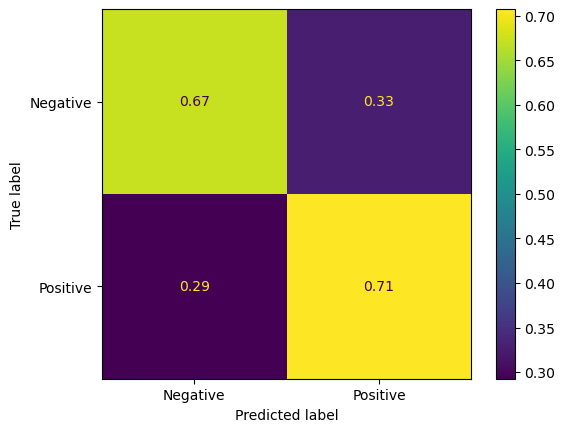

In [33]:
# Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_hat = model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
cm_test = confusion_matrix(y_test, y_hat, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()


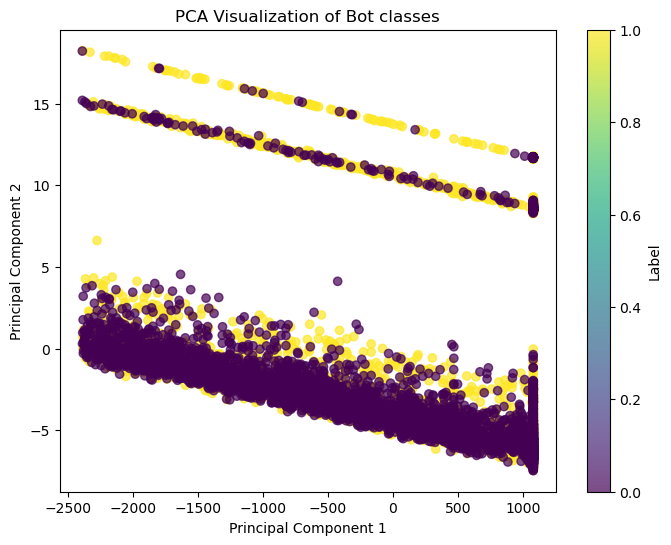

In [34]:
# Inspiration: https://www.datacamp.com/tutorial/introduction-t-sne
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# PCA reduces feature space by finding directions that capture the most variance
pca = PCA(n_components=3, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title("PCA Visualization of Bot classes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Label')
plt.show()

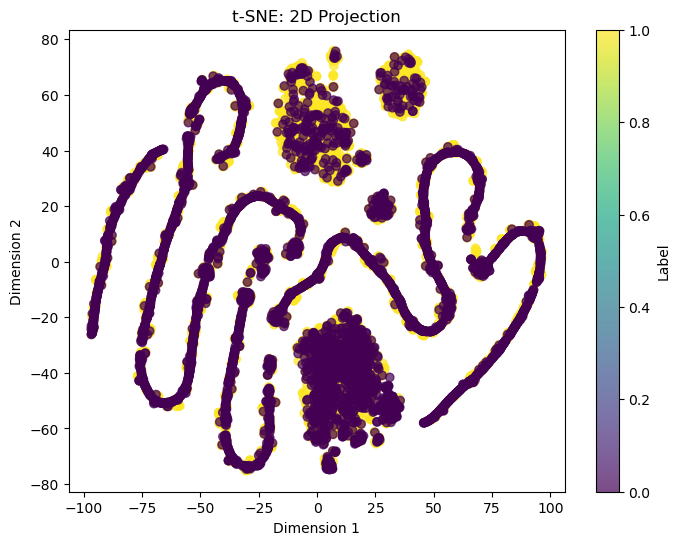

In [35]:
# Interesting, but doesn't preserve local structure very well, let's look at t-SNE
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, random_state=RANDOM_STATE).fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title("t-SNE: 2D Projection")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(label='Label')
plt.show()

In [36]:
# We'll try with a Random Forest now
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Accuracy: 0.75
F1 Score: 0.74
Precision: 0.78
Recall: 0.70


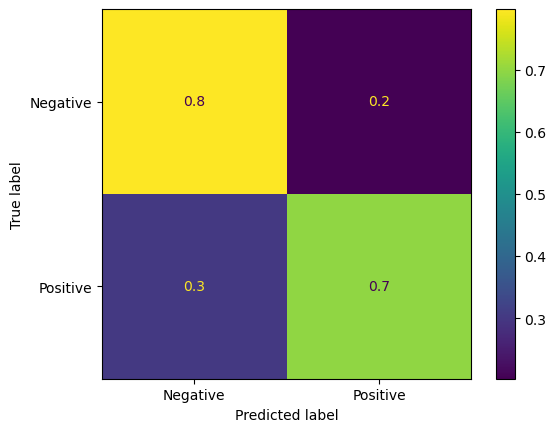

In [37]:
y_hat = rf_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()

Accuracy: 0.66
F1 Score: 0.67
Precision: 0.67
Recall: 0.67


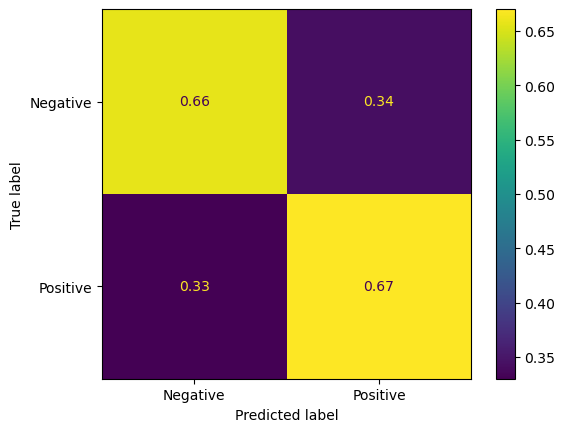

In [38]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree.fit(X_train, y_train)

y_hat = tree.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()

Accuracy: 0.68
F1 Score: 0.61
Precision: 0.80
Recall: 0.49


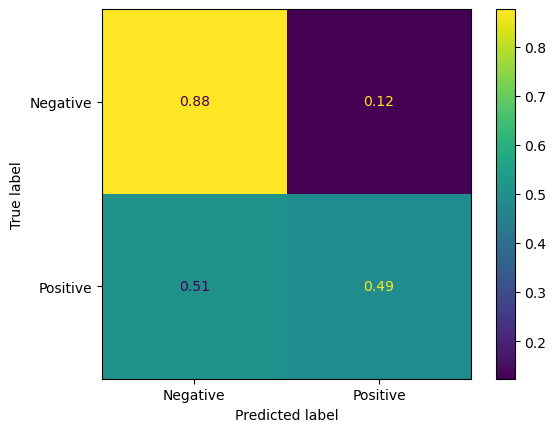

In [39]:
# Naive-Bayes
from sklearn.naive_bayes import GaussianNB

bayes_model = GaussianNB()
bayes_model.fit(X_train, y_train)

y_hat = bayes_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()

Accuracy: 0.66
F1 Score: 0.65
Precision: 0.68
Recall: 0.63


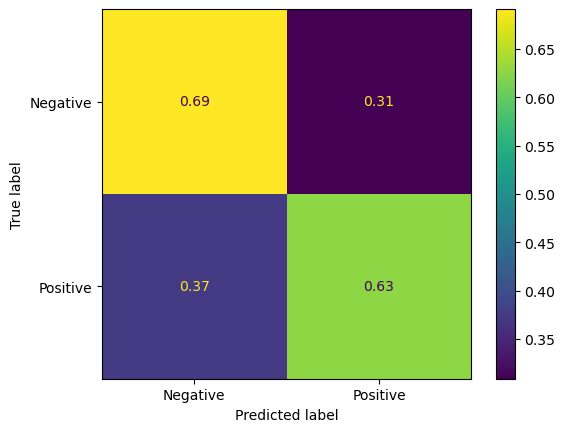

In [40]:
# k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_hat = knn.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()

In [41]:
# Deep Learning Model
# inspired by: https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/
# from deep_learning.dataloader import Bot_Dataset
# from deep_learning.nn_model import DNN
from torch.utils.data import random_split, DataLoader

In [42]:
from torch.optim import Adam
import torch.nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

dvc = 'cuda' if torch.cuda.is_available() else 'cpu'

datapath = "./data"

dataset = Bot_Dataset(datapath)

all_train_losses = {}
all_val_losses = {}
all_best_losses = {}
model_names = []

# Create DataLoaders after splitting dataset into train and test
length = len(dataset)
train_len = int(0.8 * length)
test_len = int(0.2 * length)

train_dataset, test_dataset = random_split(dataset, [train_len, test_len], torch.Generator().manual_seed(42))

train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_scalar_features = dataset.scalar[0].shape[0]

def train_model(learning_rate: int = 1e-4, weight_decay: int = 0.0, channels: int = 16):
    model = DNN(num_scalar_features=num_scalar_features, output_channels=channels).to(dvc)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=10,
        eps=1e-4
    )

    class EarlyStopping:
        def __init__(self, patience=20, mode='max'):
            self.patience = patience
            self.mode = mode
            self.best = None
            self.bad_epochs = 0

        def step(self, current):
            improve = (self.best is None) or (current > self.best if self.mode == 'max' else current < self.best)

            if improve:
                self.best = current
                self.bad_epochs = 0
                return False # do not stop yet
            else:
                self.bad_epochs += 1
                return self.bad_epochs >= self.patience

    early_stopper = EarlyStopping(patience=20, mode='min')


    # Training loop
    best_loss = np.inf
    train_losses = []
    val_losses = []
    model_name = f"lr{learning_rate:.0e}_wd:{weight_decay:.0e}_ch{channels}"

    for epoch in range(1, 201):
        model.train()

        train_loss_total = 0.0
        train_acc = 0.0
        total_samples = 0

        for inputs, scalars, targets in train_dl: 
            # Cast inputs and targets to prevent typing conflicts with model
            inputs = inputs.float().to(dvc)
            scalars = scalars.float().to(dvc)
            targets = targets.long().to(dvc) # needs to be of type long for loss function
            # Clear current gradient (accumulates otherwise)
            optimizer.zero_grad()
            yhat = model(inputs, scalars)

            # Calculate loss and backpropagate
            loss = criterion(yhat, targets)
            loss.backward()

            # Clip gradients to prevent them from exploding to infinity
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Update model weights
            optimizer.step()

            train_loss_total += loss.item()
            train_acc += (yhat.argmax(dim=1) == targets).sum().item()
            total_samples += targets.size(0)

        avg_train_loss = train_loss_total / len(train_dl)
        train_losses.append(avg_train_loss)

        train_acc /= total_samples

        # Evaluate model performance
        val_loss_total = 0.0
        val_acc = 0.0
        total_samples = 0

        model.eval()
        for inputs, scalars, targets in test_dl:
            inputs = inputs.float().to(dvc)
            scalars = scalars.float().to(dvc)
            targets = targets.long().to(dvc)
            
            yhat = model(inputs, scalars)
            val_loss = criterion(yhat, targets)
            val_loss_total += val_loss.item()
            val_acc += (yhat.argmax(dim=1) == targets).sum().item()
            total_samples += targets.size(0)
        
        avg_val_loss = val_loss_total / len(test_dl)
        val_losses.append(avg_val_loss)
        
        val_acc /= total_samples

        if epoch % 5 == 0:
            print(f"Logging... epoch: {epoch}, train_loss: {avg_train_loss}, val_loss: {avg_val_loss}, train_acc: {train_acc}, val_acc: {val_acc}")
        
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            all_best_losses[model_name] = best_loss
            torch.save(model.state_dict(), f"models/{model_name}_best_model.pt")
            print(f"New best model saved at epoch: {epoch}.")

        if early_stopper.step(avg_val_loss):
            print(f"Early stop at epoch: {epoch}. No improvement detected.")
            torch.save(model.state_dict(), f"models/{model_name}_early_stop.pt")
            all_train_losses[model_name] = train_losses
            all_val_losses[model_name] = val_losses
            model_names.append(model_name)
            break
    
    all_train_losses[model_name] = train_losses
    all_val_losses[model_name] = val_losses
    model_names.append(model_name)
        

In [ ]:
from itertools import product

param_grid = {
    'lr': [5e-3, 1e-3, 5e-4, 1e-4],
    'wd': [0.0, 1e-4],
    'ch': [16, 32, 64]
}

for lr, wd, ch in product(param_grid['lr'], param_grid['wd'], param_grid['ch']):
    train_model(learning_rate=lr, weight_decay=wd, channels=ch)

New best model saved at epoch: 1.
New best model saved at epoch: 2.
Logging... epoch: 5, train_loss: 1.6133881949186326, val_loss: 1.3125544379627894, train_acc: 0.57425, val_acc: 0.58
Logging... epoch: 10, train_loss: 1.3971034345626832, val_loss: 2.162011507957701, train_acc: 0.583375, val_acc: 0.5225
New best model saved at epoch: 12.
Logging... epoch: 15, train_loss: 1.7429479355812072, val_loss: 1.1039948472900996, train_acc: 0.554625, val_acc: 0.6055
Logging... epoch: 20, train_loss: 1.468631179869175, val_loss: 0.9225332992417472, train_acc: 0.580125, val_acc: 0.6345
New best model saved at epoch: 21.
New best model saved at epoch: 23.
Logging... epoch: 25, train_loss: 1.073628870368004, val_loss: 1.0354917650184934, train_acc: 0.5935, val_acc: 0.602
Logging... epoch: 30, train_loss: 1.0287635704278946, val_loss: 0.9355801741282145, train_acc: 0.615, val_acc: 0.6555
Logging... epoch: 35, train_loss: 0.7846957371234894, val_loss: 0.5576254247672974, train_acc: 0.649, val_acc: 0.7

/tmp/ipykernel_1806851/4288165108.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/tmp/ipykernel_1806851/4288165108.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


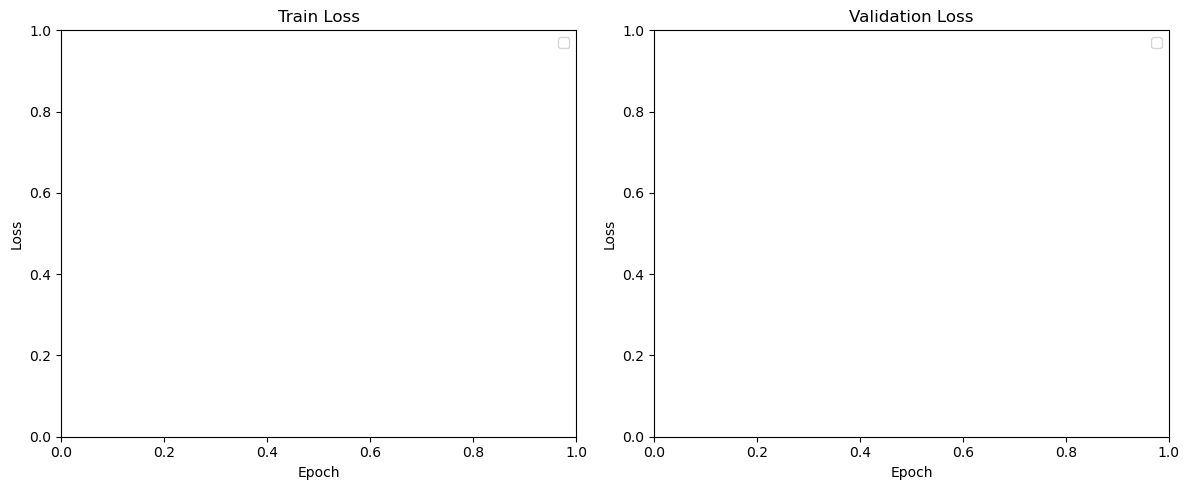

In [ ]:
import matplotlib.pyplot as plt

# Compute final val-loss for each model
final_val = {name: all_val_losses[name][-1] for name in model_names}
# Get the 5 best (lowest loss)
best5 = sorted(final_val, key=final_val.get)[:5]

# now plot the top 5
plt.figure(figsize=(12,5))

# Train loss curves
plt.subplot(1,2,1)
for name in best5:
    plt.plot(all_train_losses[name], label=name)
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

# Val loss curves
plt.subplot(1,2,2)
for name in best5:
    plt.plot(all_val_losses[name], label=name)
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [ ]:
from torch.utils.data import Subset

top_params = [
    {'lr': 5e-4, 'wd': 0.0, 'ch': 16},
    {'lr': 1e-3, 'wd': 0.0, 'ch': 32},
    {'lr': 5e-4, 'wd': 0.0, 'ch': 32},
    {'lr': 1e-3, 'wd': 0.0, 'ch': 64},
    {'lr': 5e-3, 'wd': 0.0, 'ch': 32}
]

# Take top 5 models from hyperparameter tuning and perform cross-fold-validation to determine best model overall
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

model_fold_performance = {}

for params in top_params:
    learning_rate = params['lr']
    weight_decay = params['wd']
    channels = params['ch']

    model_name = f"lr{learning_rate:.0e}_wd:{weight_decay:.0e}_ch{channels}"
    
    fold_avg = 0.0

    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        train_subset = Subset(dataset, train_ids)
        val_subset = Subset(dataset, test_ids)

        train_dl = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_dl = DataLoader(val_subset, batch_size=32, shuffle=False)

        model = DNN(output_channels=channels, num_scalar_features=num_scalar_features).to(dvc)

        model_name = f"lr{learning_rate:.0e}_wd:{weight_decay:.0e}_ch{channels}"
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=10,
            eps=1e-4
        )

        class EarlyStopping:
            def __init__(self, patience=20, mode='max'):
                self.patience = patience
                self.mode = mode
                self.best = None
                self.bad_epochs = 0

            def step(self, current):
                improve = (self.best is None) or (current > self.best if self.mode == 'max' else current < self.best)

                if improve:
                    self.best = current
                    self.bad_epochs = 0
                    return False # do not stop yet
                else:
                    self.bad_epochs += 1
                    return self.bad_epochs >= self.patience

        early_stopper = EarlyStopping(patience=20, mode='min')

        best_acc = 0.0

        for epoch in range(1, 201):
            model.train()

            train_loss_total = 0.0
            train_acc = 0.0
            total_samples = 0

            for inputs, scalars, targets in train_dl: 
                # Cast inputs and targets to prevent typing conflicts with model
                inputs = inputs.float().to(dvc)
                scalars = scalars.float().to(dvc)
                targets = targets.long().to(dvc) # needs to be of type long for loss function
                # Clear current gradient (accumulates otherwise)
                optimizer.zero_grad()
                yhat = model(inputs, scalars)

                # Calculate loss and backpropagate
                loss = criterion(yhat, targets)
                loss.backward()

                # Clip gradients to prevent them from exploding to infinity
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                # Update model weights
                optimizer.step()

                train_loss_total += loss.item()
                train_acc += (yhat.argmax(dim=1) == targets).sum().item()
                total_samples += targets.size(0)

            avg_train_loss = train_loss_total / len(train_dl)

            train_acc /= total_samples

            # Evaluate model performance
            val_loss_total = 0.0
            val_acc = 0.0
            total_samples = 0

            model.eval()
            with torch.no_grad():
                for inputs, scalars, targets in val_dl:
                    inputs = inputs.float().to(dvc)
                    scalars = scalars.float().to(dvc)
                    targets = targets.long().to(dvc)
                    
                    yhat = model(inputs, scalars)
                    val_loss = criterion(yhat, targets)
                    val_loss_total += val_loss.item()
                    val_acc += (yhat.argmax(dim=1) == targets).sum().item()
                    total_samples += targets.size(0)
                
                avg_val_loss = val_loss_total / len(val_dl)                
                val_acc /= total_samples

            if epoch % 5 == 0:
                print(f"Logging... epoch: {epoch}, train_loss: {avg_train_loss}, val_loss: {avg_val_loss}, train_acc: {train_acc}, val_acc: {val_acc}")
            
            scheduler.step(avg_val_loss)
            
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f"models/{model_name}_best_model.pt")
                print(f"New best model saved at epoch: {epoch}.")

            if early_stopper.step(avg_val_loss):
                print(f"Early stop at epoch: {epoch}. No improvement detected.")
                torch.save(model.state_dict(), f"models/{model_name}_early_stop.pt")
                break
        fold_avg += best_acc
    fold_avg /= kfold.get_n_splits()
    model_fold_performance[model_name] = fold_avg

for name in model_fold_performance.keys():
    print(f"Model: {name}, avg val acc: {model_fold_performance[name]}")



New best model saved at epoch: 1.
Logging... epoch: 5, train_loss: 0.6442756227254868, val_loss: 0.7580593348968596, train_acc: 0.657375, val_acc: 0.5835
New best model saved at epoch: 7.
Logging... epoch: 10, train_loss: 0.6872977050542831, val_loss: 0.5767046373987955, train_acc: 0.633625, val_acc: 0.696
Logging... epoch: 15, train_loss: 0.6463009344339371, val_loss: 0.62515474974163, train_acc: 0.649125, val_acc: 0.665
Logging... epoch: 20, train_loss: 0.6438113471269608, val_loss: 0.749489617489633, train_acc: 0.64675, val_acc: 0.542
New best model saved at epoch: 21.
Logging... epoch: 25, train_loss: 0.6102777645587921, val_loss: 0.5719604033326345, train_acc: 0.675875, val_acc: 0.714
New best model saved at epoch: 25.
Logging... epoch: 30, train_loss: 0.609827523112297, val_loss: 0.5590168970917898, train_acc: 0.677, val_acc: 0.702
Logging... epoch: 35, train_loss: 0.6296306496858597, val_loss: 0.5778780546453264, train_acc: 0.67825, val_acc: 0.7095
Logging... epoch: 40, train_lo

In [ ]:
# Splits were performed in different libraries, for accurate comparison against other baseline models, use original test split and reformat data:
train_df = X_train
test_df = X_test

desc_cols = [f"description{i}" for i in range(1, 769)]
twt_cols = [f"twt_{i}" for i in range(1, 769)]
name_cols = [f"name{i}" for i in range(1, 769)]

desc_np = train_df[desc_cols].values.astype(np.float32) 
twt_np  = train_df[twt_cols].values.astype(np.float32)  
name_np = train_df[name_cols].values.astype(np.float32) 
tokens = np.stack([desc_np, twt_np, name_np], axis=-1) # new shape: [n, 768, 3]
tokens = np.transpose(tokens, (0, 2, 1)) # reshape for ResNet

train_df = train_df.drop(columns = desc_cols + twt_cols + name_cols)
scalar_features = train_df.values.astype(np.float32)

# Convert X and y to torch tensors
X_train_tensor = torch.from_numpy(tokens)
y_train_tensor = torch.from_numpy(y_train.values)
scalar_train = torch.from_numpy(scalar_features)

desc_np = test_df[desc_cols].values.astype(np.float32) 
twt_np  = test_df[twt_cols].values.astype(np.float32)  
name_np = test_df[name_cols].values.astype(np.float32) 
tokens = np.stack([desc_np, twt_np, name_np], axis=-1) # new shape: [n, 768, 3]
tokens = np.transpose(tokens, (0, 2, 1)) # reshape for ResNet

test_df = test_df.drop(columns = desc_cols + twt_cols + name_cols)
scalar_features = test_df.values.astype(np.float32)

# Convert X and y to torch tensors
X_test_tensor = torch.from_numpy(tokens)
y_test_tensor = torch.from_numpy(y_test.values)
scalar_test = torch.from_numpy(scalar_features)

In [ ]:
# Best-performing model, evaluate performance
# Model: lr5e-04_wd:0e+00_ch32, avg val acc: 0.7352000000000001
model = DNN(output_channels=32, num_scalar_features=num_scalar_features).to(dvc)

train_data = torch.utils.data.TensorDataset(X_train_tensor, scalar_train, y_train_tensor)
eval_data = torch.utils.data.TensorDataset(X_test_tensor, scalar_test, y_test_tensor)

train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
eval_dl = DataLoader(eval_data, batch_size=32, shuffle=False)

criterion = torch.nn.CrossEntropyLoss()

val_loss_total = 0.0
val_acc = 0.0
total_samples = 0

criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=5e-04, weight_decay=0.0)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=10,
    eps=1e-4
)

class EarlyStopping:
    def __init__(self, patience=20, mode='max'):
        self.patience = patience
        self.mode = mode
        self.best = None
        self.bad_epochs = 0

    def step(self, current):
        improve = (self.best is None) or (current > self.best if self.mode == 'max' else current < self.best)

        if improve:
            self.best = current
            self.bad_epochs = 0
            return False # do not stop yet
        else:
            self.bad_epochs += 1
            return self.bad_epochs >= self.patience

early_stopper = EarlyStopping(patience=20, mode='min')

best_acc = 0.0

y_hat_cm = []

for epoch in range(1, 201):
    y_hat_curr = [] # For confusion matrix
    model.train()

    train_loss_total = 0.0
    train_acc = 0.0
    total_samples = 0

    for inputs, scalars, targets in train_dl: 
        # Cast inputs and targets to prevent typing conflicts with model
        inputs = inputs.float().to(dvc)
        scalars = scalars.float().to(dvc)
        targets = targets.long().to(dvc) # needs to be of type long for loss function
        # Clear current gradient (accumulates otherwise)
        optimizer.zero_grad()
        yhat = model(inputs, scalars)

        # Calculate loss and backpropagate
        loss = criterion(yhat, targets)
        loss.backward()

        # Clip gradients to prevent them from exploding to infinity
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update model weights
        optimizer.step()

        train_loss_total += loss.item()
        train_acc += (yhat.argmax(dim=1) == targets).sum().item()
        total_samples += targets.size(0)

    avg_train_loss = train_loss_total / len(train_dl)

    train_acc /= total_samples

    # Evaluate model performance
    val_loss_total = 0.0
    val_acc = 0.0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for inputs, scalars, targets in eval_dl:
            inputs = inputs.float().to(dvc)
            scalars = scalars.float().to(dvc)
            targets = targets.long().to(dvc)
            
            yhat = model(inputs, scalars)

            y_hat_curr.append(yhat.argmax(dim=1))

            val_loss = criterion(yhat, targets)
            val_loss_total += val_loss.item()
            val_acc += (yhat.argmax(dim=1) == targets).sum().item()
            total_samples += targets.size(0)
        
        avg_val_loss = val_loss_total / len(eval_dl)                
        val_acc /= total_samples

    if epoch % 5 == 0:
        print(f"Logging... epoch: {epoch}, train_loss: {avg_train_loss}, val_loss: {avg_val_loss}, train_acc: {train_acc}, val_acc: {val_acc}")
    
    scheduler.step(avg_val_loss)
    
    if val_acc > best_acc:
        y_hat_cm = y_hat_curr
        best_acc = val_acc
        print(f"New best model saved at epoch: {epoch}.")

    if early_stopper.step(avg_val_loss):
        print(f"Early stop at epoch: {epoch}. No improvement detected.")
        break

New best model saved at epoch: 1.
New best model saved at epoch: 2.
New best model saved at epoch: 4.
Logging... epoch: 5, train_loss: 0.6633107563257218, val_loss: 0.6613055382456098, train_acc: 0.636, val_acc: 0.67
New best model saved at epoch: 7.
Logging... epoch: 10, train_loss: 0.6355069364309311, val_loss: 0.644417302949088, train_acc: 0.65825, val_acc: 0.67
Logging... epoch: 15, train_loss: 0.6442682396173477, val_loss: 0.5923404092826541, train_acc: 0.659, val_acc: 0.681
New best model saved at epoch: 18.
Logging... epoch: 20, train_loss: 0.6454826784133911, val_loss: 0.5798466082603212, train_acc: 0.641, val_acc: 0.6965
Logging... epoch: 25, train_loss: 0.6607677289247513, val_loss: 0.7658235705088056, train_acc: 0.639625, val_acc: 0.5955
Logging... epoch: 30, train_loss: 0.6308225623369217, val_loss: 0.6041530616699703, train_acc: 0.653, val_acc: 0.6805
New best model saved at epoch: 33.
Logging... epoch: 35, train_loss: 0.650193800330162, val_loss: 0.5535868373182085, train

AttributeError: 'list' object has no attribute 'cpu'

In [ ]:
for i in range(len(y_hat_cm)):
    y_hat_cm[i] = y_hat_cm[i].cpu().numpy()
y_hat_cm = np.concatenate(y_hat_cm)

print(f"Model final accuracy: {best_acc}")

Model final accuracy: 0.7355


Accuracy: 0.74
F1 Score: 0.75
Precision: 0.72
Recall: 0.77


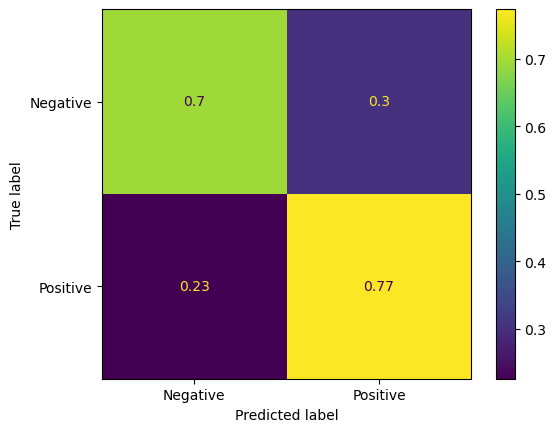

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(y_test, y_hat_cm)
f1 = f1_score(y_test, y_hat_cm, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat_cm, average='binary')
recall = recall_score(y_test, y_hat_cm, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat_cm, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()